<a href="https://colab.research.google.com/github/muceraaa/SMART-POTATO-FARMING/blob/main/mobilenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive

In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving PlantVillage.zip to PlantVillage.zip


In [ ]:
import zipfile
import os

zip_path = "PlantVillage.zip"
extract_path = "PlantVillage"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)


In [ ]:
print(os.listdir(extract_path))


['PlantVillage']


In [ ]:
actual_data_path = os.path.join(extract_path, "PlantVillage")


In [ ]:
# Constants
BATCH_SIZE = 32
IMAGE_SIZE = 224
CHANNELS = 3



In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    actual_data_path,      # Path to PlantVillage folder
    seed=123,
    shuffle=True,
    image_size=(256, 256),
    batch_size=32
)


Found 2015 files belonging to 2 classes.


In [ ]:
# Class names
class_names = dataset.class_names
print("Class Names:", class_names)

Class Names: ['Potato___Late_blight', 'Potato___healthy']


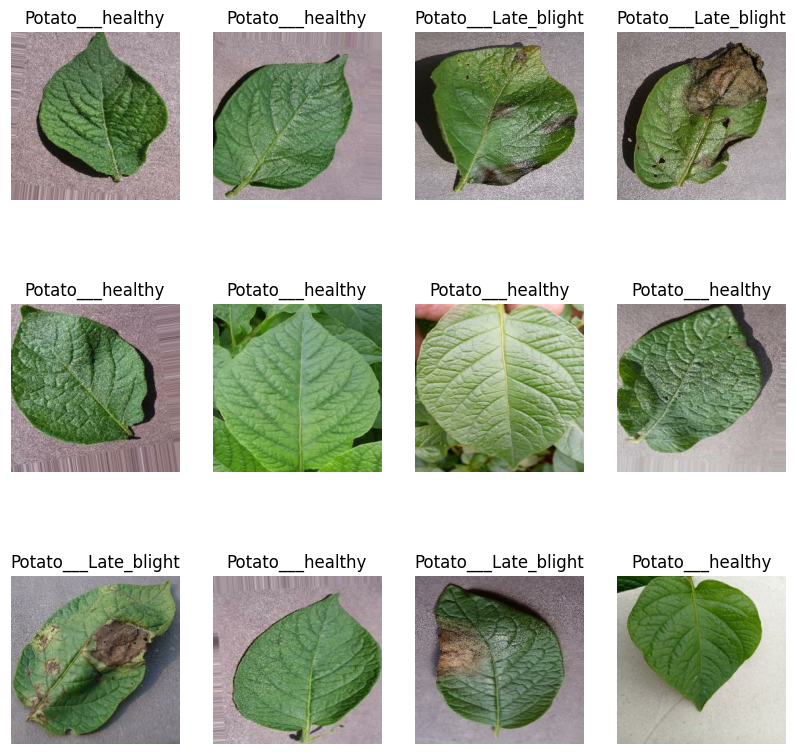

In [ ]:
# Visualize some sample images
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")


In [ ]:
# Split dataset
train_size = 0.7
val_size = 0.1
test_size = 0.2

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.7, val_split=0.1, test_split=0.2, shuffle=True, shuffle_size=10000):
    assert (train_split + val_split + test_split) == 1, "Splits must sum to 1"

    # Count elements in the dataset
    ds_size = sum(1 for _ in ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds


In [ ]:
import tensorflow as tf
IMAGE_SHAPE = (IMAGE_SIZE, IMAGE_SIZE)

# 1. Load dataset from directory
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    actual_data_path,
    seed=123,
    shuffle=True,
    image_size=IMAGE_SHAPE,
    batch_size=BATCH_SIZE
)

# 2. Split function
def get_dataset_partitions_tf(ds, train_split=0.7, val_split=0.1, test_split=0.2):
    assert (train_split + val_split + test_split) == 1

    ds = ds.shuffle(1000, seed=12)
    ds_size = tf.data.experimental.cardinality(ds).numpy()

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return (
        train_ds.prefetch(tf.data.AUTOTUNE),
        val_ds.prefetch(tf.data.AUTOTUNE),
        test_ds.prefetch(tf.data.AUTOTUNE)
    )

# 3. Split dataset
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)


Found 2015 files belonging to 2 classes.


In [ ]:
print("Train batches:", tf.data.experimental.cardinality(train_ds).numpy())
print("Validation batches:", tf.data.experimental.cardinality(val_ds).numpy())
print("Test batches:", tf.data.experimental.cardinality(test_ds).numpy())


Train batches: 44
Validation batches: 6
Test batches: 13


In [ ]:
# Optimize performance with caching and prefetching
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


PRE-PROCESSING

In [ ]:
# resizing and normalizing pixel values
resize_and_rescale = tf.keras.Sequential([
  tf.keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  tf.keras.layers.Rescaling(1.0/255) # Normalizing the pixel values helps training converge faster and more accurately.
])

train_ds = train_ds.map(lambda x, y: (resize_and_rescale(x), y))
val_ds = val_ds.map(lambda x, y: (resize_and_rescale(x), y))
test_ds = test_ds.map(lambda x, y: (resize_and_rescale(x), y))


In [ ]:
# data augmentation

def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.rot90(image, tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))
    image = tf.image.random_brightness(image, max_delta=0.1)
    return image, label

train_ds = train_ds.map(augment)


In [ ]:
# Shape of our training batch
for img, label in train_ds.take(1):
    print("New shape:", img.shape)


New shape: (32, 224, 224, 3)


MOBILENET V2

In [ ]:
# Load MobileNet V2 as the base model
IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [ ]:
# Freezing the Base
base_model.trainable = False

In [ ]:
# Adding our pooling layer
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

In [ ]:
# Adding the prediction Layer
prediction_layer = keras.layers.Dense(4, activation="softmax")

In [ ]:
# Now we will combine these layers together in a model.
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])


In [ ]:
model.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │         5,124 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,263,108 (8.63 MB)

 Trainable params: 5,124 (20.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
learning_rate = 0.001

model.compile( optimizer = keras.optimizers.Adam(learning_rate=learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])


In [ ]:
# Now we can train it on our images
history = model.fit(train_ds,
                    epochs=10,
                    validation_data=val_ds)

Epoch 1/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 11s 125ms/step - accuracy: 0.9870 - loss: 0.0535 - val_accuracy: 0.9792 - val_loss: 0.0500
Epoch 2/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 10s 118ms/step - accuracy: 0.9878 - loss: 0.0425 - val_accuracy: 0.9896 - val_loss: 0.0320
Epoch 3/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 11s 146ms/step - accuracy: 0.9894 - loss: 0.0405 - val_accuracy: 0.9948 - val_loss: 0.0301
Epoch 4/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 9s 112ms/step - accuracy: 0.9828 - loss: 0.0449 - val_accuracy: 0.9896 - val_loss: 0.0294
Epoch 5/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 101ms/step - accuracy: 0.9885 - loss: 0.0388 - val_accuracy: 0.9896 - val_loss: 0.0262
Epoch 6/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - accuracy: 0.9896 - loss: 0.0320 - val_accuracy: 0.9948 - val_loss: 0.0251
Epoch 7/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 103ms/step - accuracy: 0.9901 - loss: 0.0278 - val_accuracy: 0.9896 - val_loss: 0.0260
Epoch 8/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 97ms/step - accuracy: 0.9931 - loss: 0.0266 - val_accuracy: 0

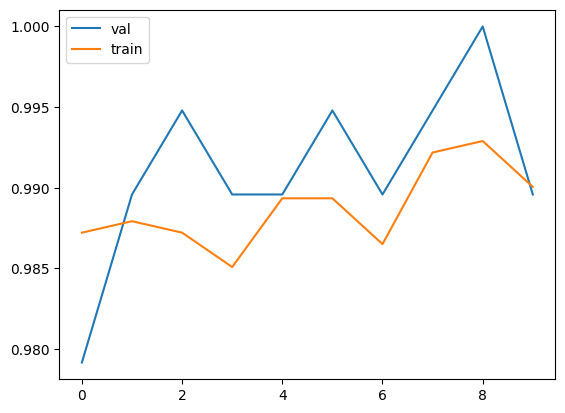

In [ ]:
hist = history.history
plt.plot(hist['val_accuracy'], label='val')
plt.plot(hist['accuracy'], label='train')

plt.legend()


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred))


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step
[[205   3]
 [  0 208]]
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       208
           1       0.99      1.00      0.99       208

    accuracy                           0.99       416
   macro avg       0.99      0.99      0.99       416
weighted avg       0.99      0.99      0.99       416



In [ ]:
# Evaluate the model on the test dataset
scores = model.evaluate(test_ds)
print("Test accuracy:", scores[1])


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 0.9924 - loss: 0.0328
Test accuracy: 0.9927884340286255


In [ ]:
# Save the model
model.save('mnet.h5')

Saving 5ea316eb-10a2-42c0-b781-40d90356ccaa___RS_HL 1935.JPG to 5ea316eb-10a2-42c0-b781-40d90356ccaa___RS_HL 1935.JPG
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


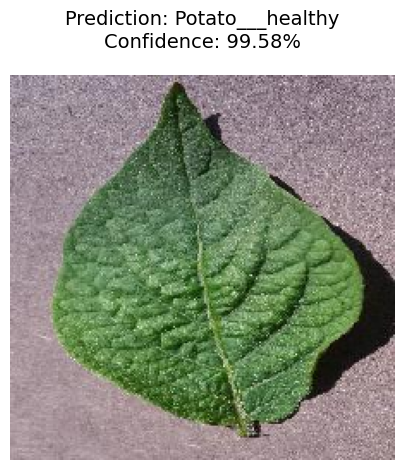

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow import keras
from google.colab import files

# Constants
IMAGE_SIZE = 224
classes =  ['Potato___Late_blight', 'Potato___healthy']

# Load your model (make sure it's uploaded to Colab or in your Drive)
model = keras.models.load_model('mnet.h5')

# Upload image file from your local device
uploaded = files.upload()  # You can select an image file from your computer

# Get uploaded image path
img_path = list(uploaded.keys())[0]  # This takes the first uploaded file name

def predict_and_display(model, img_path, class_names=classes):
    # Load and preprocess the image
    img = image.load_img(img_path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize

    # Make prediction
    predictions = model.predict(img_array)
    predicted_class_index = np.argmax(predictions[0])
    predicted_class = class_names[predicted_class_index]
    confidence_score = predictions[0][predicted_class_index]

    # Display image and prediction
    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Prediction: {predicted_class}\nConfidence: {confidence_score:.2%}", fontsize=14, pad=20)
    plt.show()

# Run prediction
predict_and_display(model, img_path)
